In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
import nltk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud, STOPWORDS
# from transformers import pipeline  # Dikomentari sementara
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Dari data ini digunakan hanya review & ratting
df = pd.read_csv("dataMieGacoan.csv")

In [3]:
df.head(7)

,Unnamed: 0,nama_tempat,user,review,rating
0,0,Mie Gacoan Tangsel - Ciater Raya,lia faroh,"Oke jadi gini, ini tuh Gacoannya luas banget y...",5
1,1,Mie Gacoan Tangsel - Ciater Raya,Dewi Novitasari,"Pas pertama kali makan dine in, biasanya selal...",5
2,2,Mie Gacoan Tangsel - Ciater Raya,Rima Risa,"Jauh2 kesini karna gacoan deket rumah kurengg,...",3
3,3,Mie Gacoan Tangsel - Ciater Raya,herman Q,Harganya beda-beda kemaren makan gacoan di dae...,4
4,4,Mie Gacoan Tangsel - Ciater Raya,Adelita Adella,"Pertama kali cobain mie gacoan, beli jam 12 ma...",4
5,5,Mie Gacoan Tangsel - Ciater Raya,Sonia Sari,First time bgt makan di gacoan yang cabang Cia...,1
6,6,Mie Gacoan Tangsel - Ciater Raya,и,"untuk makanannya oke sih standar gacoan, tp pe...",3


In [4]:
# hanya menggunakan kolom review dan rating
df = df [["review", "rating"]]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  500 non-null    object
 1   rating  500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [6]:
df['review'] = df['review'].astype(str).str.lower()
df['review'] = df['review'].replace('false', pd.NA)
df = df.dropna(subset=['review'])
df = df[df['review'] != 'false']

In [7]:
df = df.drop_duplicates(subset = ["review"])

In [8]:
def clean_rmaps_text(text):
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)  # Remove mentions (@username)
    text = re.sub(r'#\w+', ' ', text)            # Remove hashtags
    text = re.sub(r'RT[\s]+', ' ', text)         # Remove RT (retweets)
    text = re.sub(r'https?://\S+', ' ', text)    # Remove URLs
    
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)  # Remove special characters except letters/numbers
    text = re.sub(r'\s+', ' ', text).strip()     # Remove extra whitespace
    
    return text

df['review'] = df['review'].apply(clean_rmaps_text)

# Prepocessing

**NORMALISASI**

In [9]:
# Normalisasi
norm = {
    ' bm ': ' bcnn ',
    ' yg ': ' yang ',
    ' thn ': ' tahun ',
    ' uk ': ' ',
    ' bpk ': ' bapak ',
    ' lg ': ' lagi ',
    ' kyk ': ' kayak ',
    ' mkan ': ' makan ',
    ' bljr ': ' belajar ',
    ' org ': ' orang ',
    ' one ': ' satu ',
    ' dg ': ' dengan ',
    ' lail ': ' lupa ',
    ' miktr2 ': ' miktr ',
    ' siaapp ': ' slap ',
    ' okaay ': ' oke ',
    ' udh ': ' sudah '
}

def normalisasi(str_text):
    for i in norm:
        str_text = str_text.replace(i, norm[i])
    return str_text

df['review'] = df['review'].apply(lambda x: normalisasi(x))
df

,review,rating
0,oke jadi gini ini tuh gacoannya luas banget ya...,5
1,pas pertama kali makan dine in biasanya selalu...,5
2,jauh2 kesini karna gacoan deket rumah kurengg ...,3
3,harganya beda beda kemaren makan gacoan di dae...,4
4,pertama kali cobain mie gacoan beli jam 12 mal...,4
...,...,...
495,ngojek antriannya sejam,1
496,tempatnya nyaman pelayanannya juga okee,5
497,oke makan disini makanan sampe snack nya masih...,5
498,tempatnya enak nyaman buat ngobrol dan makan s...,5


**Stopwords**

In [10]:
# Stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, ArrayDictionary

# Initialize stopword remover
factory = StopWordRemoverFactory()
stop_words = factory.get_stop_words()
more_stop_words = []  # Add custom stopwords here if needed
stop_words.extend(more_stop_words)

# Create stopword remover
stopword_remover = factory.create_stop_word_remover()

def remove_stopwords(text):
    return stopword_remover.remove(text)

# Apply to dataframe
df['review'] = df['review'].apply(remove_stopwords)
df.head()

,review,rating
0,oke jadi gini tuh gacoannya luas banget tempat...,5
1,pas pertama kali makan dine in biasanya selalu...,5
2,jauh2 kesini karna gacoan deket rumah kurengg ...,3
3,harganya beda beda kemaren makan gacoan daerah...,4
4,pertama kali cobain mie gacoan beli jam 12 mal...,4


**Tokenize**

In [11]:
tokenized = df['review'].apply(lambda x: x.split())
tokenized.head()

0    [oke, jadi, gini, tuh, gacoannya, luas, banget...
1    [pas, pertama, kali, makan, dine, in, biasanya...
2    [jauh2, kesini, karna, gacoan, deket, rumah, k...
3    [harganya, beda, beda, kemaren, makan, gacoan,...
4    [pertama, kali, cobain, mie, gacoan, beli, jam...
Name: review, dtype: object

**Stemming**

In [12]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pandas as pd

stemmer = StemmerFactory().create_stemmer()

def stem_tokenized(token_list):
    return [stemmer.stem(word) for word in token_list]

tokenized = tokenized.apply(stem_tokenized)
tokenized_str = tokenized.apply(lambda x: ' '.join(x))
tokenized_str.to_csv('hasilStemming.csv', index=False)

# Labeling

In [13]:
# Gabungkan kolom 'rating' dengan hasil stemming
hasil_stemming = pd.DataFrame({
    'review': tokenized_str,
    'rating': df['rating']
})

# Simpan ke CSV
hasil_stemming.to_csv('hasilStemming.csv', index=False)

In [14]:
df.head(10)

,review,rating
0,oke jadi gini tuh gacoannya luas banget tempat...,5
1,pas pertama kali makan dine in biasanya selalu...,5
2,jauh2 kesini karna gacoan deket rumah kurengg ...,3
3,harganya beda beda kemaren makan gacoan daerah...,4
4,pertama kali cobain mie gacoan beli jam 12 mal...,4
5,first time bgt makan gacoan cabang ciater raya...,1
6,makanannya oke sih standar gacoan tp pelayanan...,3
7,klo mau arah bsd macet parah mie gacoan saya j...,5
8,biasanya makan ditempat nyobain pesan gofood m...,1
9,langganan deket rumah baik on line makan tempa...,5


# Visualisasi

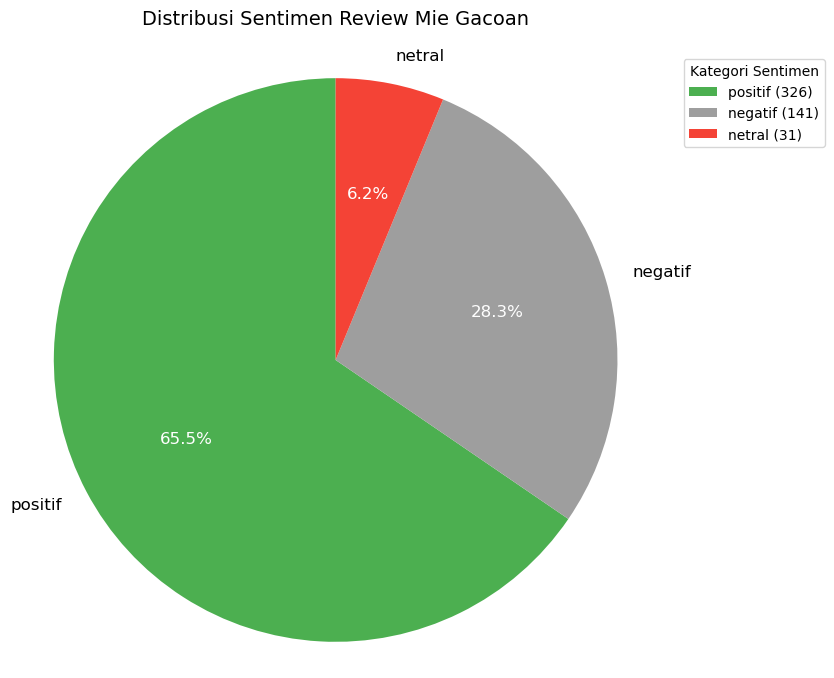

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Create sentiment column based on ratings
df['sentimen'] = df['rating'].apply(lambda x: 'positif' if x >= 4 else 'netral' if x == 3 else 'negatif')

# Now you can run your visualization code
sentimen_counts = df['sentimen'].value_counts()
sentimen_percent = df['sentimen'].value_counts(normalize=True) * 100

colors = ['#4CAF50', '#9E9E9E', '#F44336']  # hijau, abu-abu, merah

plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(
    sentimen_counts,
    labels=sentimen_counts.index,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12}
)

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('white')

plt.legend(
    title="Kategori Sentimen",
    loc="upper right",
    bbox_to_anchor=(1.3, 1),
    labels=[f"{label} ({count})" for label, count in zip(sentimen_counts.index, sentimen_counts)]
)

plt.title('Distribusi Sentimen Review Mie Gacoan', fontsize=14, pad=20)
plt.axis('equal')
plt.show()

# Model

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [18]:
# 1. Prepare Data
X = df['review']  # Text features
y = df['sentimen']  # Target variable

In [19]:
# 2. Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Maintain class distribution
)

In [20]:
# 3. Feature Extraction with TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),  # Use both single words and 2-word combinations
    stop_words='english'  # Remove English stopwords (optional)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [21]:
# 4. Build and Train Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=150,  # Number of trees
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=1,
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    n_jobs=-1  # Use all CPU cores
)

rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25,
                       min_samples_split=5, n_estimators=150, n_jobs=-1,
                       random_state=42)

In [22]:
# 5. Make Predictions
y_pred = rf_model.predict(X_test_tfidf)

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

eval_results = {
    "Accuracy": f"{accuracy:.4f}",
    "Precision": f"{precision:.4f}",
    "Recall": f"{recall:.4f}",
    "F1-Score": f"{f1:.4f}"
}

print("Hasil Evaluasi Model (Numerik):")
for metric, value in eval_results.items():
    print(f"{metric}: {value}")

Hasil Evaluasi Model (Numerik):
Accuracy: 0.8000
Precision: 0.7546
Recall: 0.8000
F1-Score: 0.7765


D:\Annaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Terimakasih